<a href="https://colab.research.google.com/github/aakanksha-27/GPU-Accelerated-Batch-Image-Filtering-Using-CUDA/blob/main/cuda_mnist_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Dec 15 13:40:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install cupy-cuda12x torchvision

In [ ]:
import cupy as cp
print(cp.cuda.runtime.getDeviceCount())

1


In [ ]:
import cupy as cp
import numpy as np
from torchvision import datasets, transforms

# Load MNIST
mnist = datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Take 500 images
images = [mnist[i][0].numpy().squeeze() for i in range(500)]

# Move to GPU
gpu_images = cp.asarray(images)

# Simple GPU convolution (edge-like kernel)
kernel = cp.array([[1, 0, -1],
                   [0, 0,  0],
                   [-1,0,  1]], dtype=cp.float32)

def convolve(img, kernel):
    h, w = img.shape
    out = cp.zeros_like(img)
    for i in range(1, h-1):
        for j in range(1, w-1):
            region = img[i-1:i+2, j-1:j+2]
            out[i, j] = cp.sum(region * kernel)
    return out

# Process images on GPU
processed = [convolve(img, kernel) for img in gpu_images]

print(f"Processed {len(processed)} images on GPU")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.32MB/s]


Processed 500 images on GPU


In [ ]:
import numpy as np

# Stack the list of CuPy arrays into a single CuPy array, then convert to NumPy
processed_np = cp.stack(processed).get()

# Save the NumPy array
np.save("processed_gpu.npy", processed_np)

In [ ]:
!nvidia-smi

Mon Dec 15 13:50:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             29W /   70W |     110MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

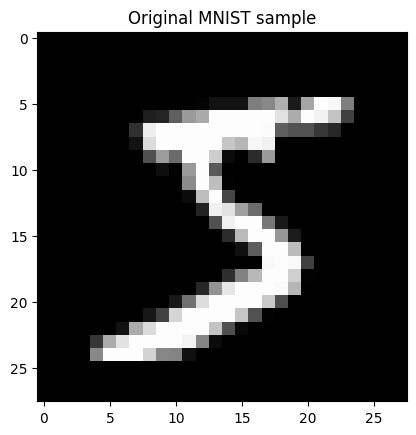

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0], cmap='gray')
plt.title("Original MNIST sample")
plt.show()

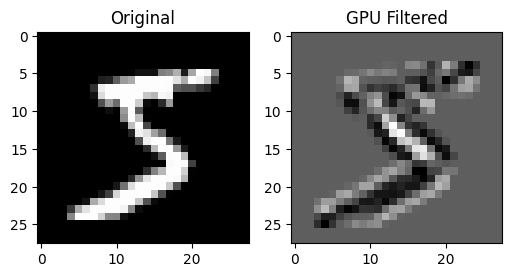

In [ ]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(images[0], cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(cp.asnumpy(processed[0]), cmap='gray')
plt.title("GPU Filtered")
plt.show()